# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting, which has been implemented in the `libs/unet_model.py` module.

In [1]:
import os
import gc
import copy

import numpy as np
from PIL import Image

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback

import matplotlib
import matplotlib.pyplot as plt

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')

from libs.util import MaskGenerator
from libs.data_loaders import DataGenerator
from libs.unet_model import InpaintingUnet

# Settings
BATCH_SIZE = 8

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let us quickly check the architecture of the network.

In [8]:
# InpaintingUnet(conv_layer='pconv').summary()
# InpaintingUnet(conv_layer='gconv').summary()

# Testing out on single image
For the purpose of checking whether the model works, we'll try training the network on a single image; i.e. training and test dataset will essentially be the same, but this is simply to validate that the network learns something.

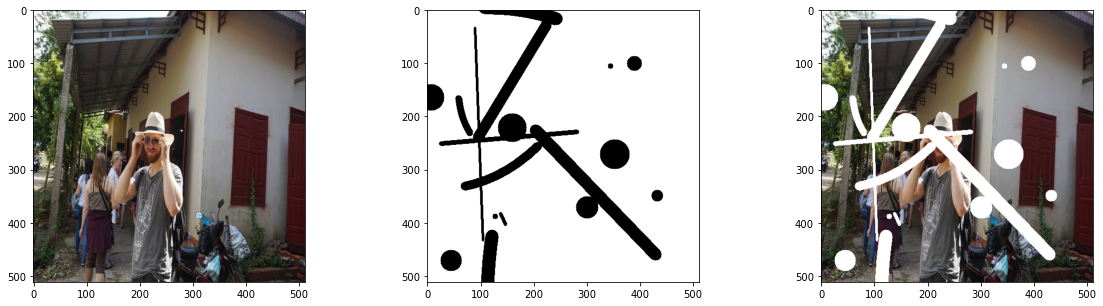

In [2]:
# Instantiate mask generator
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)

# Load image
img = np.array(Image.open('./data/sample_image.jpg').resize((512, 512))) / 255

# Load mask
mask = mask_generator.sample()

# Image + mask
masked_img = copy.deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us, except each each yielded image will be slightly altered/augmented by using `ImageDataGenerator` from `keras.processing`. 

In [5]:
def plot_sample_data(masked, mask, ori, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title(middle_title)
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()     
    
# Create datagen
datagen = DataGenerator(  
    mask_generator,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Create generator from numpy array
batch = np.stack([img for _ in range(BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=BATCH_SIZE)

NameError: name 'mask_generator' is not defined

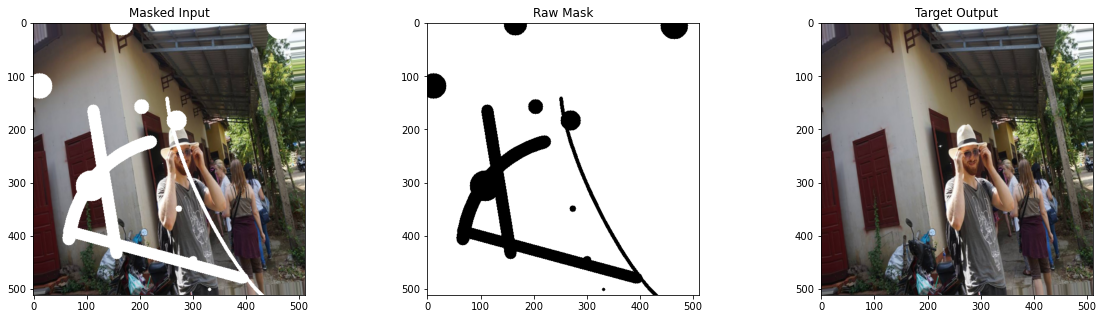

In [11]:
[m1, m2], o1 = next(generator)
plot_sample_data(m1[0], m2[0]*255, o1[0])

## Training the inpainting UNet on single image
Now that we have a generator, we can initiate our training. For conveience the `fit()` method of the `InpaintingUnet` takes a callback, which we can use to evaluate and display the progress in terms of reconstructing the target based on the masked input.

In [12]:
# Instantiate model
# model = InpaintingUnet(conv_layer='pconv')
model = InpaintingUnet(conv_layer='gconv')

Running model on 2 GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Epoch 1/10
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
2000/2000 [==============================] - 1917s 910ms/step - l1: 0.0760 - l2: 0.1761 - l3: 1.2975 - l4: 4.5613 - l5: 4.3646 - l6: 0.0045 - loss: 10.4801 - L1_error: 0.1053 - PSNR: 16.2026 - SSIM: 0.5119 - Mask_Ratio: 0.2664


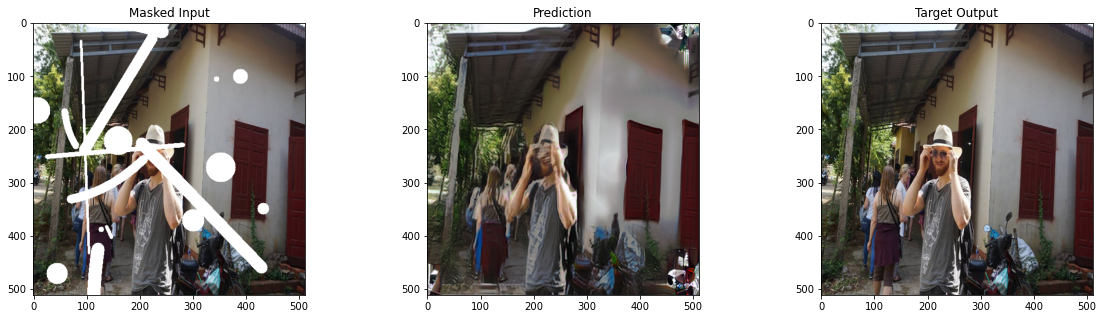

Epoch 2/10
2000/2000 [==============================] - 1794s 897ms/step - l1: 0.0357 - l2: 0.1325 - l3: 0.9931 - l4: 2.1503 - l5: 2.6391 - l6: 0.0045 - loss: 5.9551 - L1_error: 0.0577 - PSNR: 19.6945 - SSIM: 0.7027 - Mask_Ratio: 0.2694


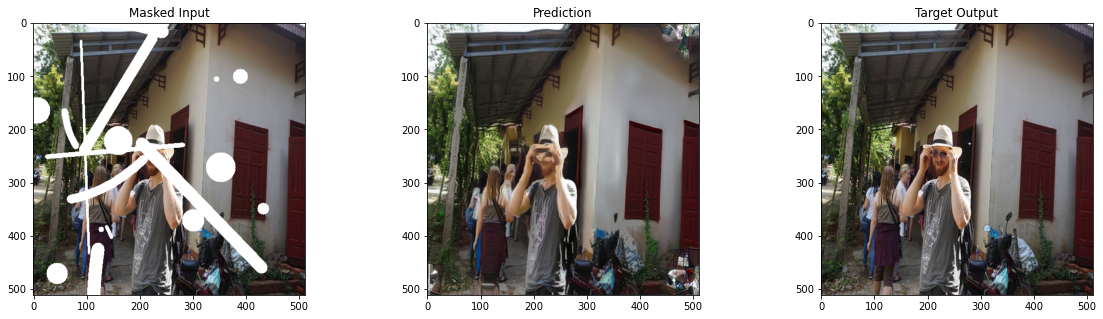

Epoch 3/10
2000/2000 [==============================] - 1783s 891ms/step - l1: 0.0281 - l2: 0.1113 - l3: 0.8723 - l4: 1.7491 - l5: 2.1772 - l6: 0.0045 - loss: 4.9426 - L1_error: 0.0467 - PSNR: 21.1875 - SSIM: 0.7478 - Mask_Ratio: 0.2677


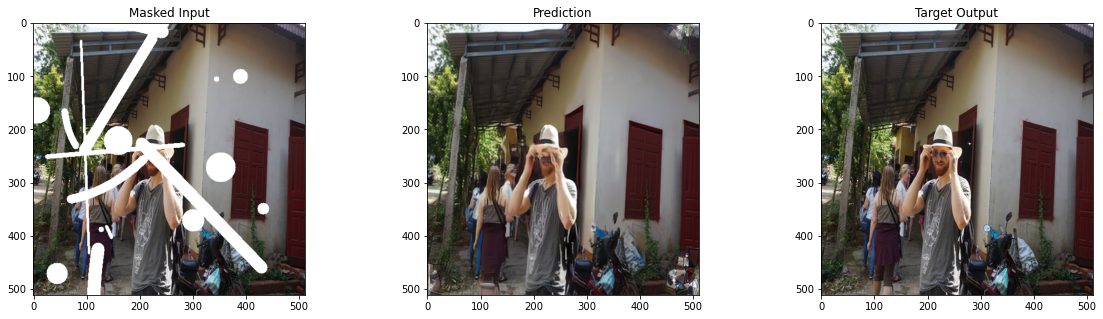

Epoch 4/10
2000/2000 [==============================] - 1785s 892ms/step - l1: 0.0235 - l2: 0.0994 - l3: 0.7908 - l4: 1.5494 - l5: 1.9135 - l6: 0.0045 - loss: 4.3811 - L1_error: 0.0401 - PSNR: 22.3887 - SSIM: 0.7758 - Mask_Ratio: 0.2683


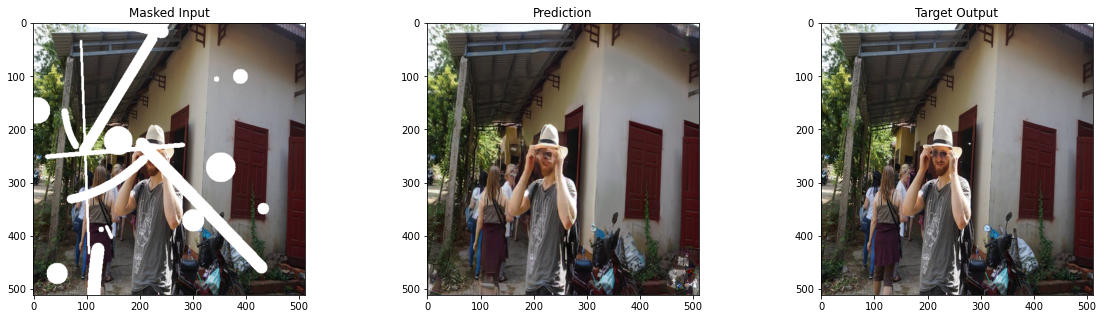

Epoch 5/10
2000/2000 [==============================] - 1784s 892ms/step - l1: 0.0203 - l2: 0.0908 - l3: 0.7225 - l4: 1.3790 - l5: 1.7248 - l6: 0.0045 - loss: 3.9419 - L1_error: 0.0354 - PSNR: 23.3181 - SSIM: 0.7993 - Mask_Ratio: 0.2675


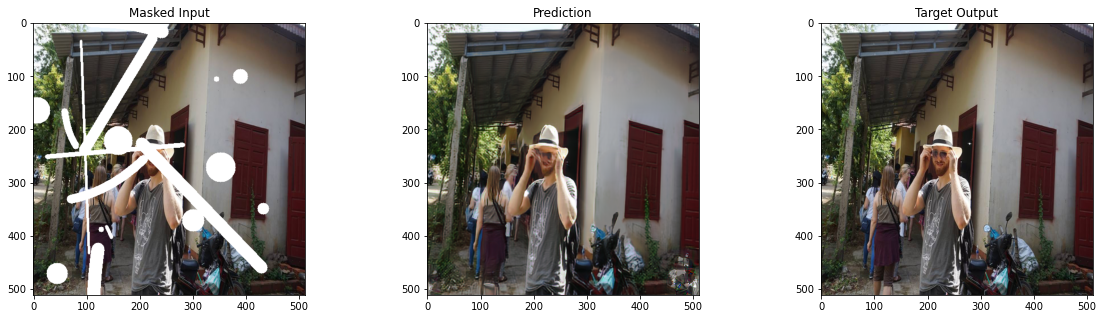

Epoch 6/10
2000/2000 [==============================] - 1784s 892ms/step - l1: 0.0179 - l2: 0.0849 - l3: 0.6671 - l4: 1.2562 - l5: 1.5972 - l6: 0.0045 - loss: 3.6278 - L1_error: 0.0321 - PSNR: 24.0733 - SSIM: 0.8185 - Mask_Ratio: 0.2669


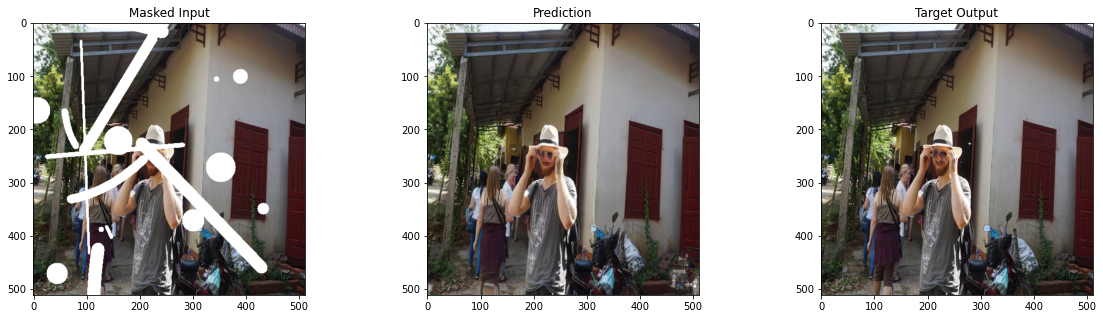

Epoch 7/10
2000/2000 [==============================] - 1787s 893ms/step - l1: 0.0160 - l2: 0.0807 - l3: 0.6226 - l4: 1.1824 - l5: 1.5032 - l6: 0.0045 - loss: 3.4094 - L1_error: 0.0294 - PSNR: 24.7286 - SSIM: 0.8338 - Mask_Ratio: 0.2681


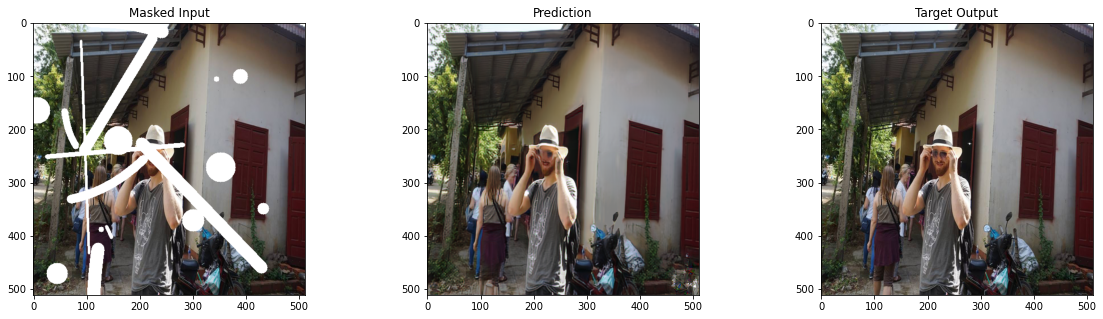

Epoch 8/10
2000/2000 [==============================] - 1784s 892ms/step - l1: 0.0145 - l2: 0.0771 - l3: 0.5844 - l4: 1.0955 - l5: 1.4180 - l6: 0.0045 - loss: 3.1941 - L1_error: 0.0273 - PSNR: 25.2982 - SSIM: 0.8460 - Mask_Ratio: 0.2679


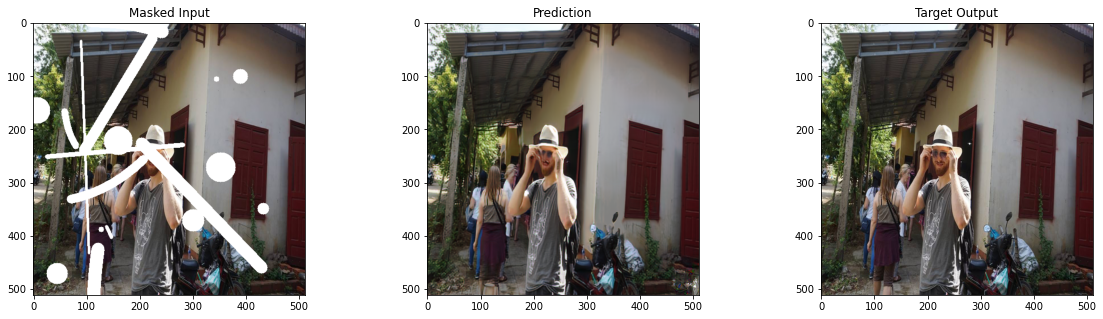

Epoch 9/10
2000/2000 [==============================] - 1784s 892ms/step - l1: 0.0133 - l2: 0.0735 - l3: 0.5505 - l4: 1.0411 - l5: 1.3463 - l6: 0.0045 - loss: 3.0292 - L1_error: 0.0256 - PSNR: 25.7997 - SSIM: 0.8567 - Mask_Ratio: 0.2666


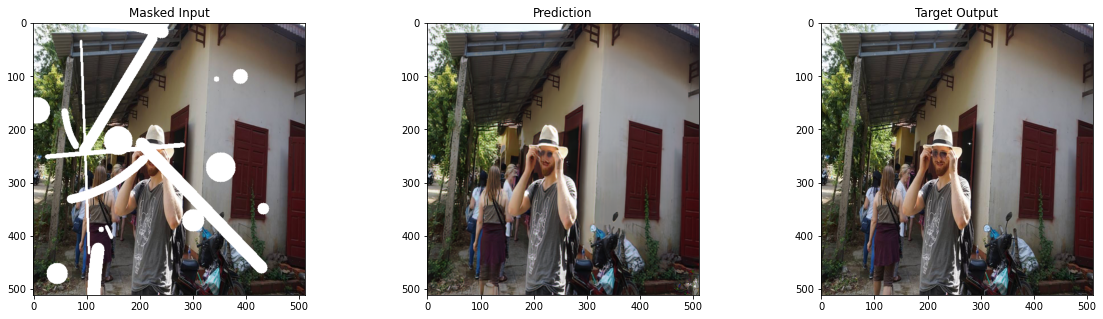

Epoch 10/10
2000/2000 [==============================] - 1783s 892ms/step - l1: 0.0125 - l2: 0.0722 - l3: 0.5303 - l4: 0.9979 - l5: 1.3063 - l6: 0.0045 - loss: 2.9236 - L1_error: 0.0245 - PSNR: 26.1318 - SSIM: 0.8628 - Mask_Ratio: 0.2689


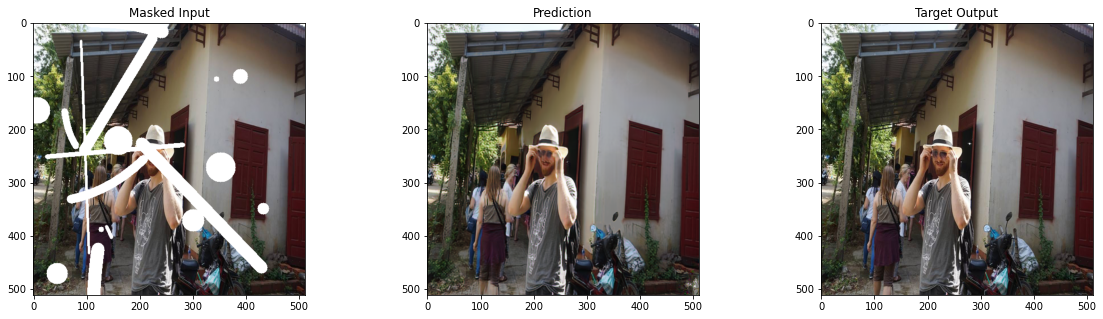

In [13]:
FOLDER = './data/logs/single_image_test'

model.fit(
    generator, 
    steps_per_epoch=2000,
    epochs=10,
    workers=4,
    callbacks=[
        TensorBoard(
            log_dir=FOLDER,
            write_graph=False
        ),
        ModelCheckpoint(
            os.path.join(FOLDER, 'weights.Epoch-{epoch:02d}.PSNR-{PSNR:.2f}'),
            monitor='PSNR', mode='max',
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask,0)
                    ]
                )[0], 
                img,
                middle_title='Prediction'
            )
        )
    ],
)